In [1]:
# -*- coding: utf-8 -*-
#   This work is part of the Core Imaging Library (CIL) developed by CCPi 
#   (Collaborative Computational Project in Tomographic Imaging), with 
#   substantial contributions by UKRI-STFC and University of Manchester.

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

from cil.optimisation.operators import LinearOperator
from cil.optimisation.operators import FiniteDifferenceOperator
from cil.framework import BlockGeometry
import warnings
from cil.utilities.multiprocessing import NUM_THREADS
from cil.framework import ImageGeometry
import numpy as np
import logging

NEUMANN = 'Neumann'
PERIODIC = 'Periodic'
C = 'c'
NUMPY = 'numpy'
CORRELATION_SPACE = "Space"
CORRELATION_SPACECHANNEL = "SpaceChannels"

class GradientOperator(LinearOperator):


    r'''Gradient Operator: Computes first-order forward/backward differences on 
        2D, 3D, 4D ImageData under Neumann/Periodic boundary conditions
    
    :param gm_domain: Set up the domain of the function
    :type gm_domain: `ImageGeometry`
    :param bnd_cond: Set the boundary conditions to use 'Neumann' or 'Periodic', defaults to 'Neumann'
    :type bnd_cond: str, optional    
    :return: returns a BlockDataContainer containing images of the derivatives order given by `dimension_labels`\
        i.e. ['horizontal_y','horizontal_x'] will return [d('horizontal_y'), d('horizontal_x')]
    :rtype: BlockDataContainer
    
    :param \**kwargs:
        See below

    :Keyword Arguments:
        * *correlation* (``str``) --
          'Space' or 'SpaceChannels', defaults to 'Space'
        * *backend* (``str``) --
          'c' or 'numpy', defaults to 'c' if correlation is 'SpaceChannels' or channels = 1
        * *num_threads* (``int``) --
          If backend is 'c' specify the number of threads to use. Default is number of cpus/2          
        * *split* (``boolean``) --
          If 'True', and backend 'C' will return a BlockDataContainer with grouped spatial domains. i.e. [Channel, [Z, Y, X]], otherwise [Channel, Z, Y, X]
                               
        Example (2D): 
        .. math::
        
          \nabla : X -> Y \\
          u\in X, \nabla(u) = [\partial_{y} u, \partial_{x} u] \\
          u^{*}\in Y, \nabla^{*}(u^{*}) = \partial_{y} v1 + \partial_{x} v2
            

    '''

    #kept here for backwards compatability
    CORRELATION_SPACE = CORRELATION_SPACE
    CORRELATION_SPACECHANNEL = CORRELATION_SPACECHANNEL

    def __init__(self, domain_geometry, method = 'forward', bnd_cond = 'Neumann', **kwargs):
        """Constructor method
        """        
        
        # Default backend = C
        backend = kwargs.get('backend',C)

        # Default correlation for the gradient coupling
        correlation = kwargs.get('correlation',CORRELATION_SPACE)

        # Add attributes for SIRF data where there is no CIL geometry
        if not isinstance(domain_geometry, ImageGeometry):
            domain_geometry.channels = 1
            domain_geometry.dimension_labels = [None]*len(domain_geometry.shape)        
                       
        # Space correlation on multichannel data call numpy backend
        if correlation == CORRELATION_SPACE and domain_geometry.channels > 1:
            #numpy implementation only for now
            backend = NUMPY
            warnings.info("Warning: correlation='Space' on multi-channel dataset will use `numpy` backend")

        # Complex data will use numpy backend
        if domain_geometry.dtype in [np.complex, np.complex64]:
            backend = NUMPY
            warnings.info("Warning: Complex geometries will use `numpy` backend")
        
        if method != 'forward':
            backend = NUMPY
            warnings.info("Warning: method = {} implemented on `numpy` backend. Other methods are backward/centered.".format(method))            
            
        if backend == NUMPY:
            self.operator = Gradient_numpy(domain_geometry, bnd_cond=bnd_cond, **kwargs)
        else:
            self.operator = Gradient_C(domain_geometry, bnd_cond=bnd_cond, **kwargs)
        
        super(GradientOperator, self).__init__(domain_geometry=domain_geometry, 
                                       range_geometry=self.operator.range_geometry()) 

    def direct(self, x, out=None):
        """Computes the first-order forward differences

        :param x: Image data
        :type x: `ImageData`
        :param out: pre-allocated output memory to store result
        :type out: `BlockDataContainer`, optional        
        :return: result data if not passed as parameter
        :rtype: `BlockDataContainer`
        """        
        return self.operator.direct(x, out=out)
        
        
    def adjoint(self, x, out=None):
        """Computes the first-order backward differences

        :param x: Gradient images for each dimension in ImageGeometry domain
        :type x: `BlockDataContainer`
        :param out: pre-allocated output memory to store result
        :type out: `ImageData`, optional      
        :return: result data if not passed as parameter
        :rtype: `ImageData`
        """            
        return self.operator.adjoint(x, out=out)

class Gradient_numpy(LinearOperator):
    
    def __init__(self, domain_geometry, method = 'forward', bnd_cond = 'Neumann', **kwargs):
        '''creator
        
        :param gm_domain: domain of the operator
        :type gm_domain: :code:`AcquisitionGeometry` or :code:`ImageGeometry`
        :param bnd_cond: boundary condition, either :code:`Neumann` or :code:`Periodic`.
        :type bnd_cond: str, optional, default :code:`Neumann`
        :param correlation: optional, :code:`SpaceChannel` or :code:`Space`
        :type correlation: str, optional, default :code:`Space`
        '''             
        
        # Consider pseudo 2D geometries with one slice, e.g., (1,voxel_num_y,voxel_num_x)
        domain_shape = []
        self.ind = []
        for i, size in enumerate(list(domain_geometry.shape) ):
            if size!=1:
                domain_shape.append(size)
                self.ind.append(i)
     
        # Dimension of domain geometry        
        self.ndim = len(domain_shape) 
        
        # Default correlation for the gradient coupling
        self.correlation = kwargs.get('correlation',CORRELATION_SPACE)        
        self.bnd_cond = bnd_cond 
        
        # Call FiniteDifference operator 
        self.method = method
        self.FD = FiniteDifferenceOperator(domain_geometry, direction = 0, method = self.method, bnd_cond = self.bnd_cond)
    
        if self.correlation==CORRELATION_SPACE and 'channel' in domain_geometry.dimension_labels:
            self.ndim -= 1
            self.ind.remove(domain_geometry.dimension_labels.index('channel'))

        range_geometry = BlockGeometry(*[domain_geometry for _ in range(self.ndim) ] )

        #get voxel spacing, if not use 1s
        try:
            self.voxel_size_order = list(domain_geometry.spacing)
        except:
            self.voxel_size_order = [1]*len(domain_geometry.shape)

        super(Gradient_numpy, self).__init__(domain_geometry = domain_geometry, 
                                             range_geometry = range_geometry) 
        
        logging.info("Initialised GradientOperator with numpy backend")           
        
    def direct(self, x, out=None): 
         if out is not None:  
             for i, axis_index in enumerate(self.ind):
                 self.FD.direction = axis_index
                 self.FD.voxel_size = self.voxel_size_order[axis_index]
                 self.FD.direct(x, out = out[i])
         else:
             tmp = self.range_geometry().allocate()        
             for i, axis_index in enumerate(self.ind):
                 self.FD.direction = axis_index
                 self.FD.voxel_size = self.voxel_size_order[axis_index]
                 tmp.get_item(i).fill(self.FD.direct(x))
             return tmp    
        
    def adjoint(self, x, out=None):

        if out is not None:
            tmp = self.domain_geometry().allocate()            
            for i, axis_index in enumerate(self.ind):
                self.FD.direction = axis_index
                self.FD.voxel_size = self.voxel_size_order[axis_index]
                self.FD.adjoint(x.get_item(i), out = tmp)
                if i == 0:
                    out.fill(tmp)
                else:
                    out += tmp
        else:            
            tmp = self.domain_geometry().allocate()
            for i, axis_index in enumerate(self.ind):
                self.FD.direction = axis_index
                self.FD.voxel_size = self.voxel_size_order[axis_index]
                tmp += self.FD.adjoint(x.get_item(i))
            return tmp 

import ctypes, platform
from ctypes import util
# check for the extension
if platform.system() == 'Linux':
    dll = 'libcilacc.so'
elif platform.system() == 'Windows':
    dll_file = 'cilacc.dll'
    dll = util.find_library(dll_file)
elif platform.system() == 'Darwin':
    dll = 'libcilacc.dylib'
else:
    raise ValueError('Not supported platform, ', platform.system())

cilacc = ctypes.cdll.LoadLibrary(dll)

c_float_p = ctypes.POINTER(ctypes.c_float)

cilacc.openMPtest.restypes = ctypes.c_int32
cilacc.openMPtest.argtypes = [ctypes.c_int32]

cilacc.fdiff4D.argtypes = [ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.c_long,
                       ctypes.c_long,
                       ctypes.c_long,
                       ctypes.c_long,
                       ctypes.c_int32,
                       ctypes.c_int32,
                       ctypes.c_int32]

cilacc.fdiff3D.argtypes = [ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.c_long,
                       ctypes.c_long,
                       ctypes.c_long,
                       ctypes.c_int32,
                       ctypes.c_int32,
                       ctypes.c_int32]

cilacc.fdiff2D.argtypes = [ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.POINTER(ctypes.c_float),
                       ctypes.c_long,
                       ctypes.c_long,
                       ctypes.c_int32,
                       ctypes.c_int32,
                       ctypes.c_int32]


class Gradient_C(LinearOperator):
    
    '''Finite Difference Operator:
            
            Computes first-order forward/backward differences 
                     on 2D, 3D, 4D ImageData
                     under Neumann/Periodic boundary conditions'''

    def __init__(self, domain_geometry,  bnd_cond = NEUMANN, **kwargs):

        # Number of threads
        self.num_threads = kwargs.get('num_threads',NUM_THREADS)
        
        # Split gradients, e.g., space and channels
        self.split = kwargs.get('split',False)
        
        # Consider pseudo 2D geometries with one slice, e.g., (1,voxel_num_y,voxel_num_x)
        self.is2D = False
        self.domain_shape = []
        self.ind = []
        self.voxel_size_order = []
        for i, size in enumerate(list(domain_geometry.shape) ):
            if size!=1:
                self.domain_shape.append(size)
                self.ind.append(i)
                self.voxel_size_order.append(domain_geometry.spacing[i])
                self.is2D = True
        
        # Dimension of domain geometry
        self.ndim = len(self.domain_shape)
                                    
        #default is 'Neumann'
        self.bnd_cond = 0
        
        if bnd_cond == PERIODIC:
            self.bnd_cond = 1
        
        # Define range geometry
        if self.split is True and 'channel' in domain_geometry.dimension_labels:
            range_geometry = BlockGeometry(domain_geometry, BlockGeometry(*[domain_geometry for _ in range(self.ndim-1)]))
        else:
            range_geometry = BlockGeometry(*[domain_geometry for _ in range(self.ndim)])
            self.split = False

        if self.ndim == 4:
            self.fd = cilacc.fdiff4D
        elif self.ndim == 3:
            self.fd = cilacc.fdiff3D
        elif self.ndim == 2:
            self.fd = cilacc.fdiff2D
        else:
            raise ValueError('Number of dimensions not supported, expected 2, 3 or 4, got {}'.format(len(domain_geometry.shape)))
        
        super(Gradient_C, self).__init__(domain_geometry=domain_geometry, 
                                         range_geometry=range_geometry) 
                                         
        logging.info("Initialised GradientOperator with C backend running with ", cilacc.openMPtest(self.num_threads)," threads")                                            
            

    @staticmethod 
    def datacontainer_as_c_pointer(x):
        ndx = x.as_array()
        return ndx, ndx.ctypes.data_as(c_float_p)

    @staticmethod 
    def ndarray_as_c_pointer(ndx):
        return ndx.ctypes.data_as(c_float_p)
        
    def direct(self, x, out=None): 
        
        ndx = np.asarray(x.as_array(), dtype=np.float32, order='C')
        x_p = Gradient_C.ndarray_as_c_pointer(ndx)
        
        return_val = False
        if out is None:
            out = self.range_geometry().allocate(None)
            return_val = True

        if self.split is False:
            ndout = [el.as_array() for el in out.containers]
        else:
            ind = self.domain_geometry().dimension_labels.index('channel')
            ndout = [el.as_array() for el in out.get_item(1).containers]
            ndout.insert(ind, out.get_item(0).as_array()) #insert channels dc at correct point for channel data
                
        #pass list of all arguments
        arg1 = [Gradient_C.ndarray_as_c_pointer(ndout[i]) for i in range(len(ndout))]
        arg2 = [el for el in self.domain_shape]
        args = arg1 + arg2 + [self.bnd_cond, 1, self.num_threads]
        self.fd(x_p, *args)

        for i, el in enumerate(self.voxel_size_order):
            if el != 1:
                ndout[i]/=el

        #fill back out in corerct (non-trivial) order
        if self.split is False:
            for i in range(self.ndim):
                out.get_item(i).fill(ndout[i])
        else:
            ind = self.domain_geometry().dimension_labels.index('channel')
            out.get_item(0).fill(ndout[ind])

            j = 0
            for i in range(self.ndim):
                if i != ind:
                    out.get_item(1).get_item(j).fill(ndout[i])
                    j +=1

        if return_val is True:
            return out        

    def adjoint(self, x, out=None):
        
        return_val = False
        if out is None:
            out = self.domain_geometry().allocate(None)
            return_val = True

        ndout = np.asarray(out.as_array(), dtype=np.float32, order='C')          
        out_p = Gradient_C.ndarray_as_c_pointer(ndout)
        
        if self.split is False: 
            ndx = [el.as_array() for el in x.containers]
        else:
            ind = self.domain_geometry().dimension_labels.index('channel')
            ndx = [el.as_array() for el in x.get_item(1).containers]
            ndx.insert(ind, x.get_item(0).as_array()) 

        for i, el in enumerate(self.voxel_size_order):
            if el != 1:
                ndx[i]/=el

        arg1 = [Gradient_C.ndarray_as_c_pointer(ndx[i]) for i in range(self.ndim)]
        arg2 = [el for el in self.domain_shape]
        args = arg1 + arg2 + [self.bnd_cond, 0, self.num_threads]

        self.fd(out_p, *args)
        out.fill(ndout)

        #reset input data
        for i, el in enumerate(self.voxel_size_order):
            if el != 1:
                ndx[i]*= el
                
        if return_val is True:
            return out        



In [2]:
# -*- coding: utf-8 -*-
#   This work is part of the Core Imaging Library (CIL) developed by CCPi 
#   (Collaborative Computational Project in Tomographic Imaging), with 
#   substantial contributions by UKRI-STFC and University of Manchester.

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

from cil.optimisation.functions import Function, IndicatorBox, MixedL21Norm
# from cil.optimisation.operators import GradientOperator
import numpy as np
from numbers import Number
import warnings



class TotalVariation(Function):
    
    r""" Total variation Function

    .. math:: \mathrm{TV}(u) := \|\nabla u\|_{2,1} = \sum \|\nabla u\|_{2},\, (\mbox{isotropic})

    .. math:: \mathrm{TV}(u) := \|\nabla u\|_{1,1} = \sum \|\nabla u\|_{1}\, (\mbox{anisotropic})

    Notes
    -----

    The :code:`TotalVariation` (TV) :code:`Function` acts as a compositite function, i.e.,
    the composition of the :class:`.MixedL21Norm` fuction and the :class:`.GradientOperator` operator,

    .. math:: f(u) = \|u\|_{2,1}, \Rightarrow (f\circ\nabla)(u) = f(\nabla x) = \mathrm{TV}(u)

    In that case, the proximal operator of TV does not have an exact solution and we use an iterative 
    algorithm to solve:

    .. math:: \mathrm{prox}_{\tau \mathrm{TV}}(b) := \underset{u}{\mathrm{argmin}} \frac{1}{2\tau}\|u - b\|^{2} + \mathrm{TV}(u)
    
    The algorithm used for the proximal operator of TV is the Fast Gradient Projection algorithm (or FISTA)
    applied to the _dual problem_ of the above problem, see :cite:`BeckTeboulle_b`, :cite:`BeckTeboulle_a`.




    Parameters
    ----------

    max_iteration : :obj:`int`, default = 100
        Maximum number of iterations for the FGP algorithm.
    tolerance : :obj:`float`, default = None
        Stopping criterion for the FGP algorithm.
        
        .. math:: \|x^{k+1} - x^{k}\|_{2} < \mathrm{tolerance}

    correlation : :obj:`str`, default = `Space`
        Correlation between `Space` and/or `SpaceChannels` for the :class:`.GradientOperator`.
    backend :  :obj:`str`, default = `c`      
        Backend to compute the :class:`.GradientOperator`
    lower : :obj:`'float`, default = `-np.inf`
        A constraint is enforced using the :class:`.IndicatorBox` function, e.g., :code:`IndicatorBox(lower, upper)`.
    upper : :obj:`'float`, default = `np.inf`
        A constraint is enforced using the :class:`.IndicatorBox` function, e.g., :code:`IndicatorBox(lower, upper)`.  
    isotropic : :obj:`boolean`, default = True
        Use either isotropic or anisotropic definition of TV.

        .. math:: |x|_{2} = \sqrt{x_{1}^{2} + x_{2}^{2}},\, (\mbox{isotropic})

        .. math:: |x|_{1} = |x_{1}| + |x_{2}|\, (\mbox{anisotropic})

    split : :obj:`boolean`, default = False
        Splits the Gradient into spatial gradient and spectral or temporal gradient for multichannel data.

    info : :obj:`boolean`, default = False
        Information is printed for the stopping criterion of the FGP algorithm

    strong_convexity_constant : :obj:`float`, default = 0
        A strongly convex term weighted by the :code:`strong_convexity_constant` (:math:`\gamma`) parameter is added to the Total variation. 
        Now the :code:`TotalVariation` function is :math:`\gamma` - strongly convex and the proximal operator is

        .. math:: \underset{u}{\mathrm{argmin}} \frac{1}{2\tau}\|u - b\|^{2} + \mathrm{TV}(u) + \frac{\gamma}{2}\|u\|^{2} \Leftrightarrow

        .. math:: \underset{u}{\mathrm{argmin}} \frac{1}{2\frac{\tau}{1+\gamma\tau}}\|u - \frac{b}{1+\gamma\tau}\|^{2} + \mathrm{TV}(u) 

    Note
    ----

    In the case where the Total variation becomes a :math:`\gamma` - strongly convex function, i.e.,

    .. math:: \mathrm{TV}(u) + \frac{\gamma}{2}\|u\|^{2}

    :math:`\gamma` should be relatively small, so as the second term above will not act as an additional regulariser.
    For more information, see :cite:`Rasch2020`, :cite:`CP2011`.




    Examples
    --------

    .. math:: \underset{u}{\mathrm{argmin}} \frac{1}{2}\|u - b\|^{2} + \alpha\|\nabla u\|_{2,1}

    >>> alpha = 2.0
    >>> TV = TotalVariation()
    >>> sol = TV.proxima(b, tau = alpha)

    Examples
    --------

    .. math:: \underset{u}{\mathrm{argmin}} \frac{1}{2}\|u - b\|^{2} + \alpha\|\nabla u\|_{1,1} + \mathbb{I}_{C}(u)

    where :math:`C = \{1.0\leq u\leq 2.0\}`.

    >>> alpha = 2.0
    >>> TV = TotalVariation(isotropic=False, lower=1.0, upper=2.0)
    >>> sol = TV.proxima(b, tau = alpha)    


    Examples
    --------

    .. math:: \underset{u}{\mathrm{argmin}} \frac{1}{2}\|u - b\|^{2} + (\alpha\|\nabla u\|_{2,1} + \frac{\gamma}{2}\|u\|^{2})

    >>> alpha = 2.0
    >>> gamma = 1e-3
    >>> TV = alpha * TotalVariation(isotropic=False, strong_convexity_constant=gamma)
    >>> sol = TV.proxima(b, tau = 1.0)    



    """   
    
    
    def __init__(self,
                 max_iteration=100, 
                 tolerance = None, 
                 correlation = "Space",
                 backend = "c",
                 lower = -np.inf, 
                 upper = np.inf,
                 isotropic = True,
                 split = False,
                 info = False, 
                 strong_convexity_constant = 0, warm = True):
        

        super(TotalVariation, self).__init__(L = None)
        # Regularising parameter = alpha
        self.regularisation_parameter = 1.
        
        # Iterations for FGP_TV
        self.iterations = max_iteration
        
        # Tolerance for FGP_TV
        self.tolerance = tolerance
        
        # Total variation correlation (isotropic=Default)
        self.isotropic = isotropic
        
        # correlation space or spacechannels
        self.correlation = correlation
        self.backend = backend        
        
        # Define orthogonal projection onto the convex set C
        self.lower = lower
        self.upper = upper
        self.projection_C = IndicatorBox(lower, upper).proximal
             
        # Setup GradientOperator as None. This is to avoid domain argument in the __init__     
        self._gradient = None
        self._domain = None

        self.pptmp = None
        self.pptmp1 = None
        
        # Print stopping information (iterations and tolerance error) of FGP_TV  
        self.info = info

        # splitting Gradient
        self.split = split

        # Strong convexity for TV
        self.strong_convexity_constant = strong_convexity_constant

        # warm-start
        self.warm = warm
        self.initial = None

    @property
    def regularisation_parameter(self):
        return self._regularisation_parameter

    @regularisation_parameter.setter
    def regularisation_parameter(self, value):
        if not isinstance(value, Number):
            raise TypeError("regularisation_parameter: expectec a number, got {}".format(type(value)))
        self._regularisation_parameter = value

    def __call__(self, x):
        
        r""" Returns the value of the TotalVariation function at :code:`x` ."""
        try:
            self._domain = x.geometry
        except:
            self._domain = x
        
        if self.strong_convexity_constant>0:
            tmp = (self.strong_convexity_constant/2)*x.squared_norm()
        else:
            tmp = 0

        if self.isotropic:
            return self.regularisation_parameter * self.gradient.direct(x).pnorm(2).sum() + tmp
        else:
            return self.regularisation_parameter * self.gradient.direct(x).pnorm(1).sum() + tmp
    
                        
    def projection_P(self, x, out=None):
                       
        r""" Returns the proximal operator of the convex conjugate of the :class:`.MixedL21Norm` at :code:`x`.
        """

        try:
            self._domain = x.geometry
        except:
            self._domain = x
        
        # preallocated in proximal
        tmp = self.pptmp
        tmp1 = self.pptmp1
        tmp1 *= 0
        
        if self.isotropic:
            for el in x.containers:
                el.conjugate().multiply(el, out=tmp)
                tmp1.add(tmp, out=tmp1)
            tmp1.sqrt(out=tmp1)
            tmp1.maximum(1.0, out=tmp1)
            if out is None:
                return x.divide(tmp1)
            else:
                x.divide(tmp1, out=out)
        else:
            tmp1 = x.abs()
            tmp1.maximum(1.0, out=tmp1) 
            if out is None:
                return x.divide(tmp1)
            else:
                x.divide(tmp1, out=out)                   
    
    
    def proximal(self, x, tau, out = None):
        
        r""" Returns the proximal operator of the TotalVariation function at :code:`x` ."""        
        try:
            self._domain = x.geometry
        except:
            self._domain = x
            
        tmp_x = self.gradient.domain_geometry().allocate(0)     
        p1 = self.gradient.range_geometry().allocate(0)              
        tmp_p = self.gradient.range_geometry().allocate(0)
        
        if self.warm:
            if self.initial is None:
                tmp_q = tmp_p.copy() 
            else:
                tmp_q = self.initial.copy()                
        else:
            tmp_q = tmp_p.copy()             

            
        # initialise
        t = 1      

        if self.strong_convexity_constant>0:
            tau /= (1+tau*self.strong_convexity_constant)
            x /= (1 + tau*self.strong_convexity_constant)

        should_break = False
        for k in range(self.iterations):

            t0 = t
            self.gradient.adjoint(tmp_q, out = tmp_x)

            # axpby now works for matrices
            tmp_x.axpby(-self.regularisation_parameter*tau, 1.0, x, out=tmp_x)
            self.projection_C(tmp_x, tau=None, out = tmp_x)                       

            self.gradient.direct(tmp_x, out=p1)
            if isinstance (tau, (Number, np.float32, np.float64)):
                p1 *= self.L/(self.regularisation_parameter * tau)
            else:
                p1 *= self.L/self.regularisation_parameter
                p1 /= tau

            if self.tolerance is not None:

                if k%5==0:
                    error = p1.norm()
                    p1 += tmp_q
                    error /= p1.norm()
                    if error<=self.tolerance:                           
                        should_break = True
                else:
                    p1 += tmp_q
            else:
                p1 += tmp_q
            if k == 0:
                # preallocate for projection_P
                self.pptmp = p1.get_item(0) * 0
                self.pptmp1 = self.pptmp.copy()

            self.projection_P(p1, out=p1)


            t = (1 + np.sqrt(1 + 4 * t0 ** 2)) / 2

            #tmp_q.fill(p1 + (t0 - 1) / t * (p1 - tmp_p))
            p1.subtract(tmp_p, out=tmp_q)
            tmp_q *= (t0-1)/t
            tmp_q += p1

            tmp_p.fill(p1)

            if should_break:
                break
        
        #clear preallocated projection_P arrays
        self.pptmp = None
        self.pptmp1 = None
        
        # Print stopping information (iterations and tolerance error) of FGP_TV     
        if self.info:
            if self.tolerance is not None:
                print("Stop at {} iterations with tolerance {} .".format(k, error))
            else:
                print("Stop at {} iterations.".format(k))                
        
        self.initial = tmp_q.copy()
        self.gradient.adjoint(self.initial, out=tmp_x)
        tmp_x *= tau
        tmp_x *= self.regularisation_parameter 
        x.subtract(tmp_x, out=tmp_x)

        return self.projection_C(tmp_x, tau=None, out=out)  
    
    def convex_conjugate(self,x):   
        r""" Returns the value of convex conjugate of the TotalVariation function at :code:`x` ."""             
        return 0.0    

    @property
    def L(self):
        r""" Lipschitz constant of the "dual" TV-problem used in the FGP algorithm."""         
        if self._L is None:
            self.calculate_Lipschitz()
        return self._L
    @L.setter
    def L(self, value):
        warnings.warn("You should set the Lipschitz constant with calculate_Lipschitz().")
        if isinstance(value, (Number,)) and value >= 0:
            self._L = value
        else:
            raise TypeError('The Lipschitz constant is a real positive number')

    def calculate_Lipschitz(self):
        r""" Default value for the Lipschitz constant."""
        
        # Compute the Lipschitz parameter from the operator if possible
        # Leave it initialised to None otherwise
        self._L = (1./self.gradient.norm())**2  
    
    @property
    def gradient(self):
        r""" GradientOperator is created using the self._domain.
        """
        if self._domain is not None:
            self._gradient = GradientOperator(self._domain, correlation = self.correlation, backend = self.backend)
        return self._gradient
    def __rmul__(self, scalar):
        if not isinstance (scalar, Number):
            raise TypeError("scalar: Expectec a number, got {}".format(type(scalar)))
        self.regularisation_parameter = scalar
        return self    

In [3]:
# Import libraries
from cil.framework import  AcquisitionGeometry
from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import BlockOperator, MatrixOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D
from cil.utilities import dataexample
from cil.plugins.astra.utilities import convert_geometry_to_astra
from cil.optimisation.functions import ZeroFunction, IndicatorBox
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.plugins import TomoPhantom

import matplotlib.pyplot as plt

from cvxpy import *
import astra

import numpy as np

In [4]:
# Detectors
N = 128
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, 0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


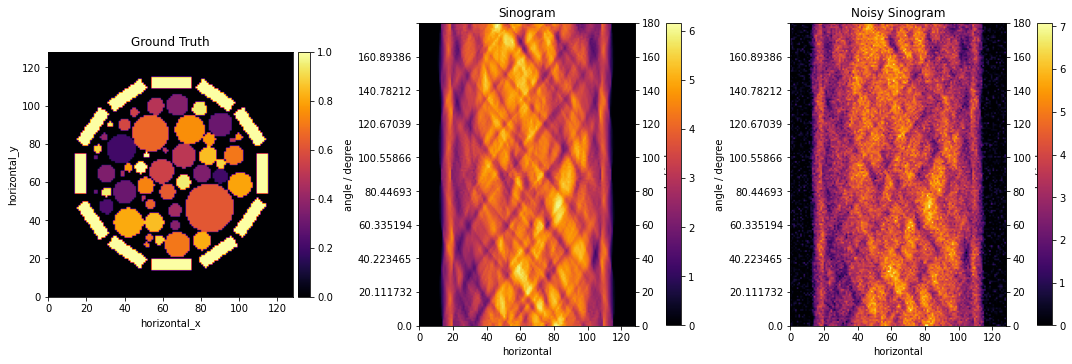

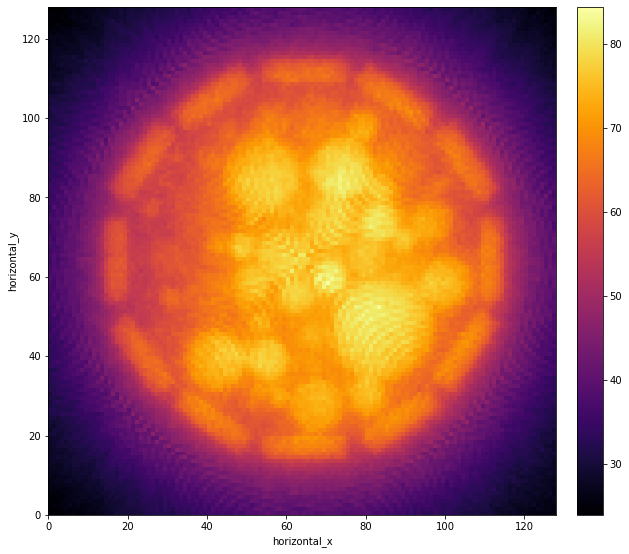

In [5]:
# Get phantom
# phantom = dataexample.SIMPLE_PHANTOM_2D.get(size=(N, N))
phantom = TomoPhantom.get_ImageData(12, ig)

# Create an acqusition data
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

np.random.seed(10)

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0
# noisy_sino.fill(sino)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], 
       title = ['Ground Truth','Sinogram','Noisy Sinogram'], 
       num_cols=3, cmap = 'inferno')

show2D(A.adjoint(noisy_sino), cmap="inferno")

In [6]:
alpha = 1.5

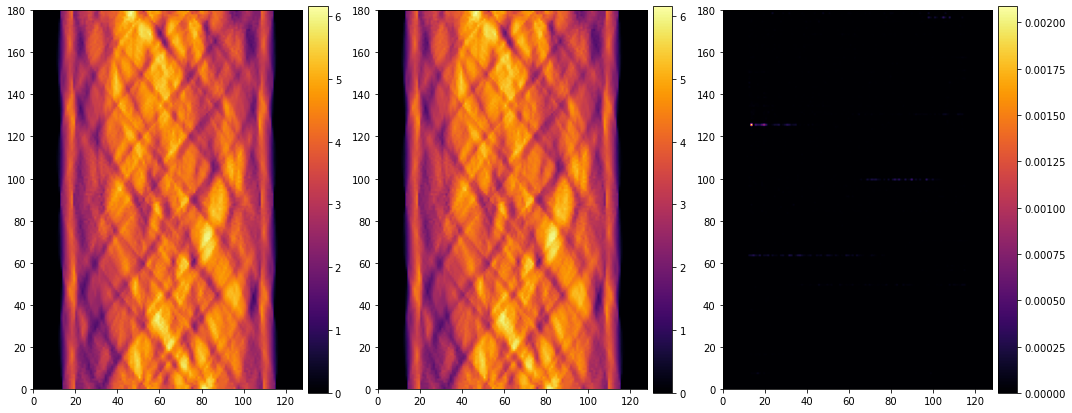

In [7]:
# convert to astra geometries
ig_astra, ag_astra = convert_geometry_to_astra(ig, ag)

# projection id
proj_id = astra.create_projector('line', ag_astra, ig_astra)

# matrix id
matrix_id = astra.projector.matrix(proj_id)

# Get the projection matrix as a Scipy sparse matrix.
W = astra.matrix.get(matrix_id)

sino_astra = (W*phantom.array.flatten()).reshape((len(ag.angles), N))

#show
show2D([sino_astra, sino.array, np.abs(sino.array-sino_astra)], num_cols=3, cmap="inferno")

# print("Norm of A_cil = {}".format(A.norm()))

# mat_cil = MatrixOperator(W.T*W)

# print("Norm of astra mat = {}".format(np.sqrt(mat_cil.norm())))



In [8]:
N, M = ig.shape
u_cvx = Variable(N*M)
fidelity = sum_squares(W@u_cvx.flatten() - noisy_sino.array.flatten())
constraints = [u_cvx>=0]

regulariser = (alpha/ig.voxel_size_x) * tv(reshape(u_cvx, (N,M))) 
obj =  Minimize( fidelity + regulariser)
prob = Problem(obj, constraints)

res = prob.solve(solver = MOSEK, verbose = True)
# res = prob.solve(solver = SCS, verbose = True, eps=1e-3)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Apr 29 11:50:00 AM: Your problem has 16384 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 29 11:50:00 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 29 11:50:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 29 11:50:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 29 11:50:00 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Apr 29 11:50:00 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

In [9]:
K = A
F = L2NormSquared(b=noisy_sino)
G = alpha*TotalVariation(max_iteration=100, tolerance=1e-3, warm=True)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg_implicit_fgp_tv_warm = PDHG(f = F, g = G, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit_fgp_tv_warm.run(verbose=0)

PDHG setting up
PDHG configured


/opt/anaconda3/envs/cil_devel_epaps/lib/python3.7/site-packages/cil/optimisation/algorithms/PDHG.py:423: UserWarning: Convergence criterion of PDHG for scalar step-sizes is not satisfied.
  warnings.warn("Convergence criterion of PDHG for scalar step-sizes is not satisfied.")


In [ ]:
G1 = alpha*TotalVariation(max_iteration=100,tolerance=0, warm=False)

# Setup and run PDHG
pdhg_implicit_fgp_tv_nowarm = PDHG(f = F, g = G1, operator = K, 
            max_iteration = 300, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit_fgp_tv_nowarm.run(verbose=0)

PDHG setting up
PDHG configured


In [ ]:
plt.rcParams.update({'font.size': 22, 'lines.linewidth': 5.})
plt.figure(figsize=(25,15))
plt.semilogy( np.abs(pdhg_implicit_fgp_tv_nowarm.objective - obj.value)/obj.value, label = "No warm", color="red")
plt.semilogy( np.abs(pdhg_implicit_fgp_tv_warm.objective - obj.value)/obj.value, label = "Warm", color="orange")
plt.legend()
plt.ylabel("Relative objective error \n from the CVXpy solution")
plt.xlabel("Iterations")
plt.show()


In [ ]:

plt.figure(figsize=(25,15))
plt.semilogy( pdhg_implicit_fgp_tv_warm.primal_dual_gap, label = "Implict (FGP_TV) warm")
plt.semilogy( pdhg_implicit_fgp_tv_nowarm.primal_dual_gap, label = "Implict (FGP_TV) no warm")
plt.legend()
plt.ylabel("Primal-Dual gap")
plt.xlabel("Iterations")
plt.show()

In [ ]:
u_cvx_sol = u_cvx.value.reshape(ig.shape)

In [ ]:
show2D([pdhg_implicit_fgp_tv_warm.solution, 
        pdhg_implicit_fgp_tv_nowarm.solution,
        u_cvx_sol,
       (pdhg_implicit_fgp_tv_warm.solution - u_cvx_sol).abs(),
       (pdhg_implicit_fgp_tv_nowarm.solution - u_cvx_sol).abs()], 
       title=['Implicit PDHG: No warm', 'Implicit PDHG: warm', 'CVX',
             'AbsDif: warm - CVX','AbsDif: no warm - CVX' ])